In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding

sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.tokenizer import CONCEPT_palette
CONCEPT_palette = pd.DataFrame([CONCEPT_palette]).T.reset_index().sort_index(ascending=False).set_index('index')[0].to_dict()

hue_order = CONCEPT_palette.keys()
hue_color = CONCEPT_palette.values()

In [3]:
dfc = pd.read_csv('../01_extract_readout//TCGA/04_features_celltype.gzip', index_col=0, compression = 'gzip')
dfl = pd.read_csv('../01_extract_readout//TCGA/00_clinical_label_orignal.csv', index_col=0)

tcga = dfc['bcr_patient_barcode'].map(dfl['cancer_type'].apply(lambda x:x.split('-')[1])).to_frame(name='cancer_type')
tcga['domain'] = 'TCGA'
tcga_dfc = tcga.join(dfc)

dfc = pd.read_csv('../01_extract_readout//ITRP/04_features_celltype.gzip', index_col=0, compression = 'gzip')
dfc = dfc.rename(columns = {'Index':'bcr_patient_barcode'})

dfl = pd.read_csv('../01_extract_readout//ITRP/00_clinical_label.csv', index_col=0)
itrp = dfc['bcr_patient_barcode'].map(dfl['cancer_type']).to_frame(name='cancer_type')

itrp['domain'] = 'ITRP'
itrp_dfc = itrp.join(dfc)

dfc = tcga_dfc._append(itrp_dfc)

In [4]:
data = dfc[dfc.columns[-32:]]
mp = PCA(n_components = 2) #
pca2d = mp.fit_transform(data)
df_pca2d  = pd.DataFrame(pca2d, index=data.index, columns = ['PCA1', 'PCA2'])

In [5]:
mp = UMAP(n_components = 2, n_neighbors= 100, n_epochs = 500,  min_dist=0.8, random_state = 42,   verbose=1 ) #
umap2d = mp.fit_transform(data)
df_umap2d  = pd.DataFrame(umap2d, index=data.index, columns = ['UMAP1', 'UMAP2'])

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.8, n_epochs=500, n_neighbors=100, random_state=42, verbose=1)
Wed Jun  5 17:59:16 2024 Construct fuzzy simplicial set
Wed Jun  5 17:59:16 2024 Finding Nearest Neighbors
Wed Jun  5 17:59:16 2024 Building RP forest with 40 trees
Wed Jun  5 17:59:22 2024 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	Stopping threshold met -- exiting after 2 iterations
Wed Jun  5 18:03:14 2024 Finished Nearest Neighbor Search
Wed Jun  5 18:03:51 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Jun  5 19:42:33 2024 Finished embedding


In [6]:
df2d = dfc[['cancer_type', 'domain', 'bcr_patient_barcode', 'feature_name']].join(df_pca2d).join(df_umap2d)

In [7]:
df2d.to_csv('celltype_space.csv.gzip', compression='gzip')

In [8]:
df2d.head()

cancer_type domain bcr_patient_barcode feature_name  \
TCGA-02-0047$$Adipocyte         GBM   TCGA        TCGA-02-0047    Adipocyte   
TCGA-02-0055$$Adipocyte         GBM   TCGA        TCGA-02-0055    Adipocyte   
TCGA-02-2483$$Adipocyte         GBM   TCGA        TCGA-02-2483    Adipocyte   
TCGA-02-2485$$Adipocyte         GBM   TCGA        TCGA-02-2485    Adipocyte   
TCGA-02-2486$$Adipocyte         GBM   TCGA        TCGA-02-2486    Adipocyte   

                             PCA1      PCA2      UMAP1      UMAP2  
TCGA-02-0047$$Adipocyte -0.159012  0.490006  32.746586  12.377198  
TCGA-02-0055$$Adipocyte -0.488275  0.402250  30.688375  13.604616  
TCGA-02-2483$$Adipocyte -0.702895  0.341148  29.921110  14.922179  
TCGA-02-2485$$Adipocyte -0.007370  0.474909  33.091110  11.169977  
TCGA-02-2486$$Adipocyte -0.646288  0.279255  28.889366  13.595063

In [4]:
df2d = pd.read_csv('celltype_space.csv.gzip', index_col=0, compression = 'gzip')

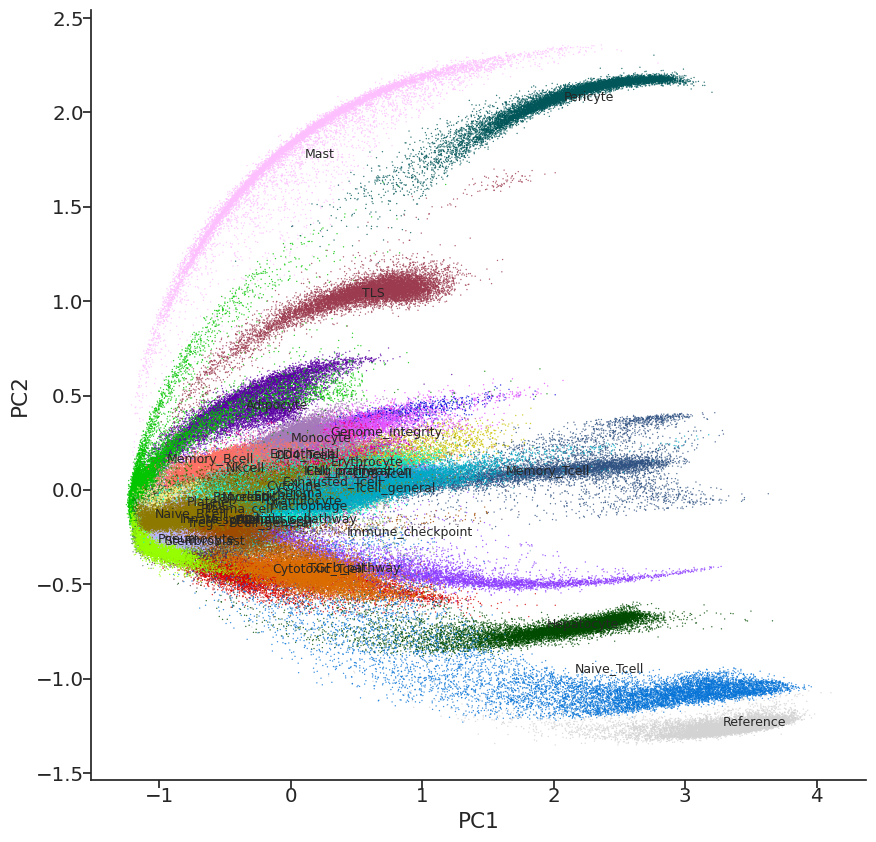

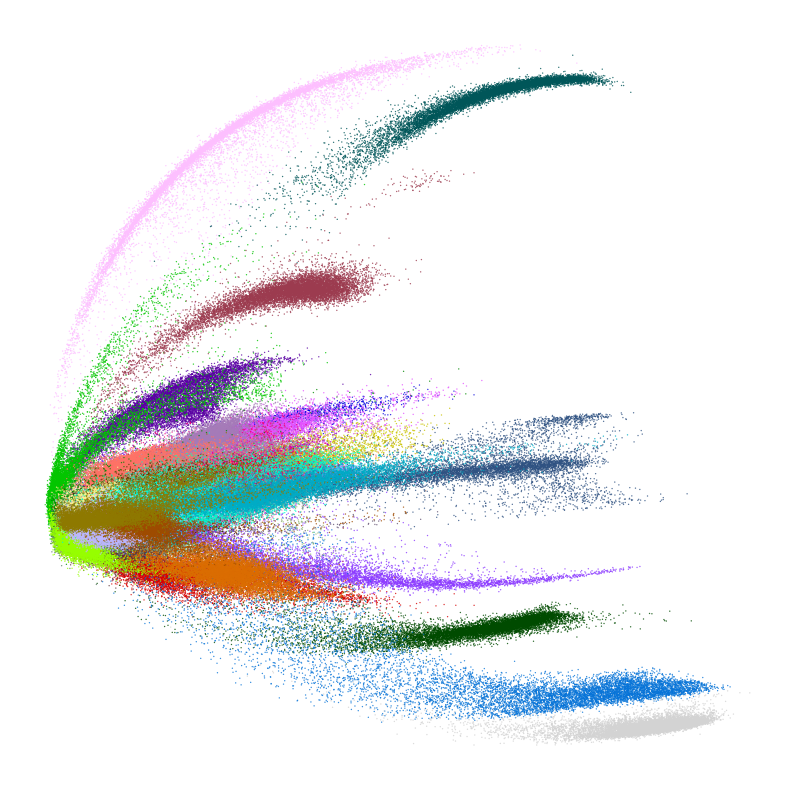

In [26]:
from matplotlib.ticker import MaxNLocator
dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].mean()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#fig.savefig('cell_TCGA_PCA_labelled.pdf')
#fig.savefig('cell_TCGA_PCA_labelled.svg')


dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

# mean = dfp.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

ax.set_xlabel('')
ax.set_ylabel('')

#ax.set_xticklabels([])
#ax.set_yticklabels([])

plt.axis('off')
#fig.savefig('cell_TCGA_PCA_unlabelled.pdf', bbox_inches ='tight')
fig.savefig('cell_TCGA_PCA_unlabelled.jpg', bbox_inches ='tight', dpi = 400)

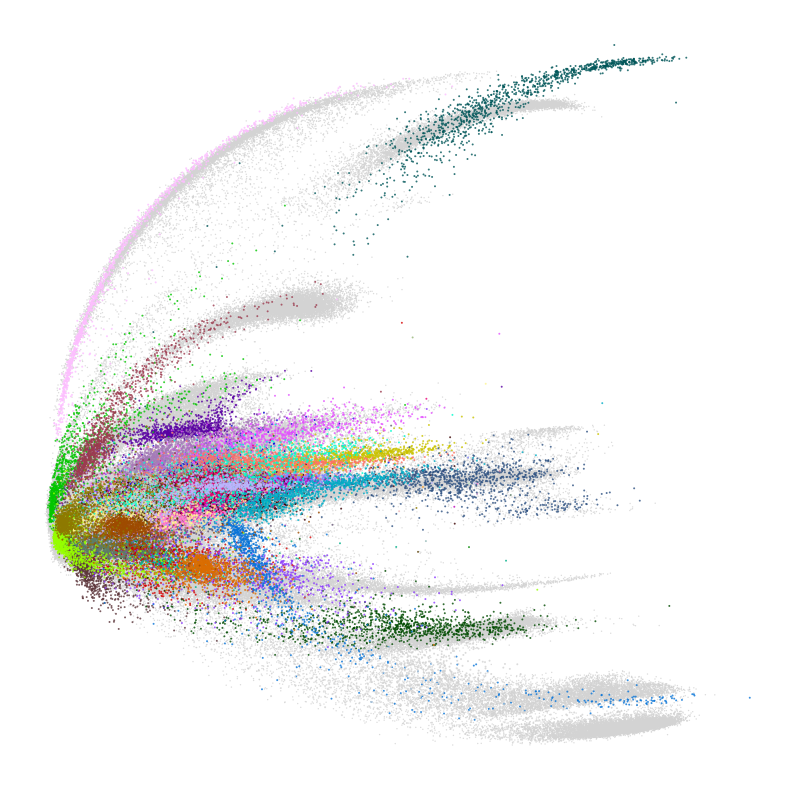

In [24]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = hue_color #{i:'#ff00ff' for i in hue_order}

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 1, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=overlay_color, s = 2, 
                 ax=ax, legend=False)

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

ax.set_xlabel('')
ax.set_ylabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axis('off')
#fig.savefig('cell_overlay_PCA_labelled.pdf', bbox_inches ='tight')
fig.savefig('cell_overlay_PCA_labelled.jpg', bbox_inches ='tight', dpi=400)

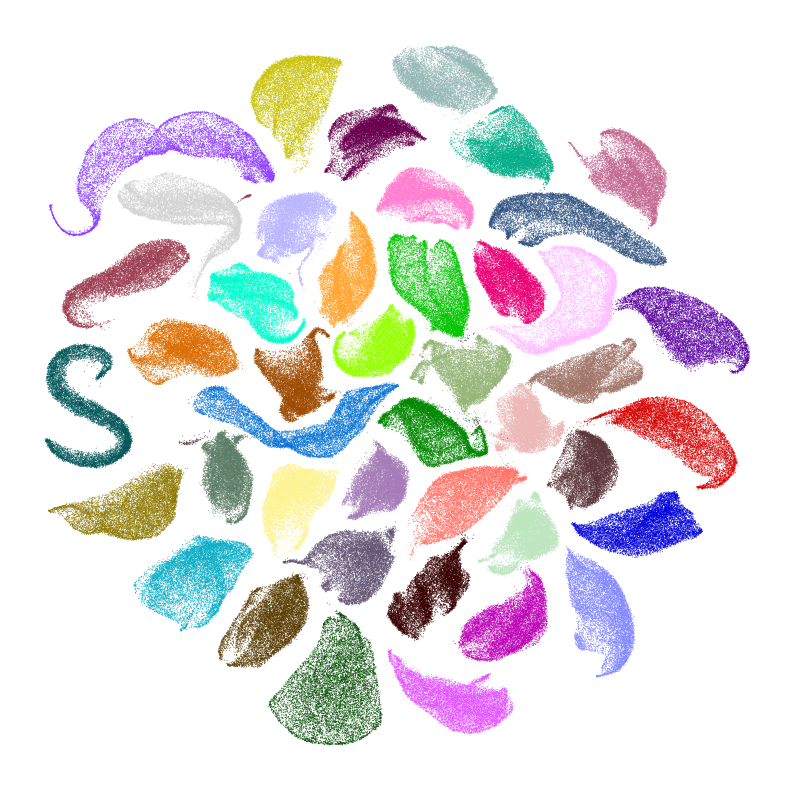

In [5]:
dfp = df2d[df2d.domain == 'TCGA']
fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

# mean = dfp.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':10})

# ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')

plt.axis('off')

fig.savefig('cell_TCGA_UMAP_unlabelled.pdf', bbox_inches ='tight')
fig.savefig('cell_TCGA_UMAP_unlabelled.jpg', bbox_inches ='tight', dpi=500)

(-17.0587692, 38.4334852, -23.04156555, 38.34095455)

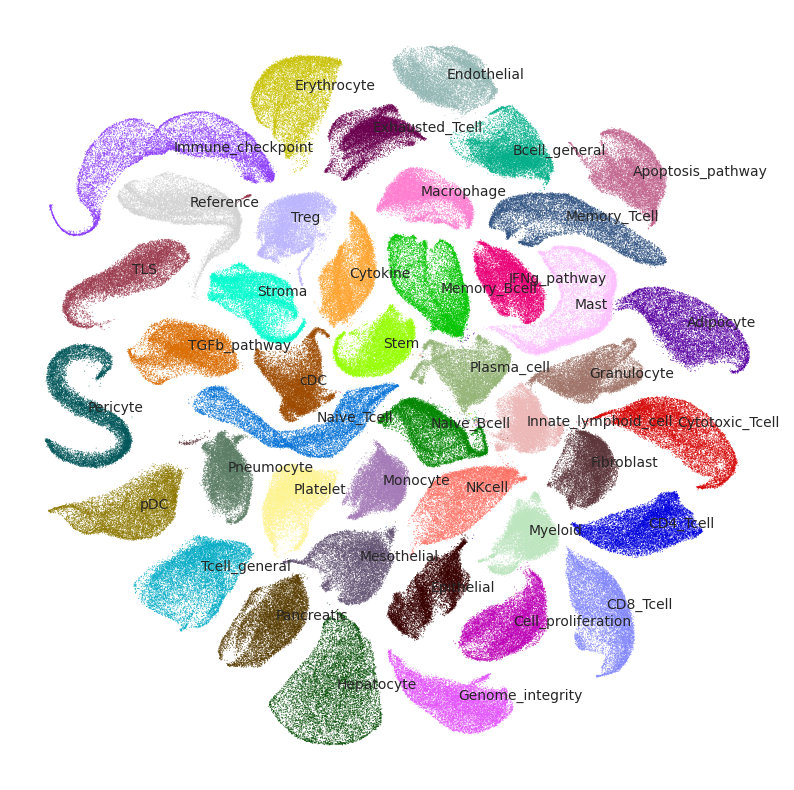

In [6]:
dfp = df2d[df2d.domain == 'TCGA']
fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':10})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')

plt.axis('off')


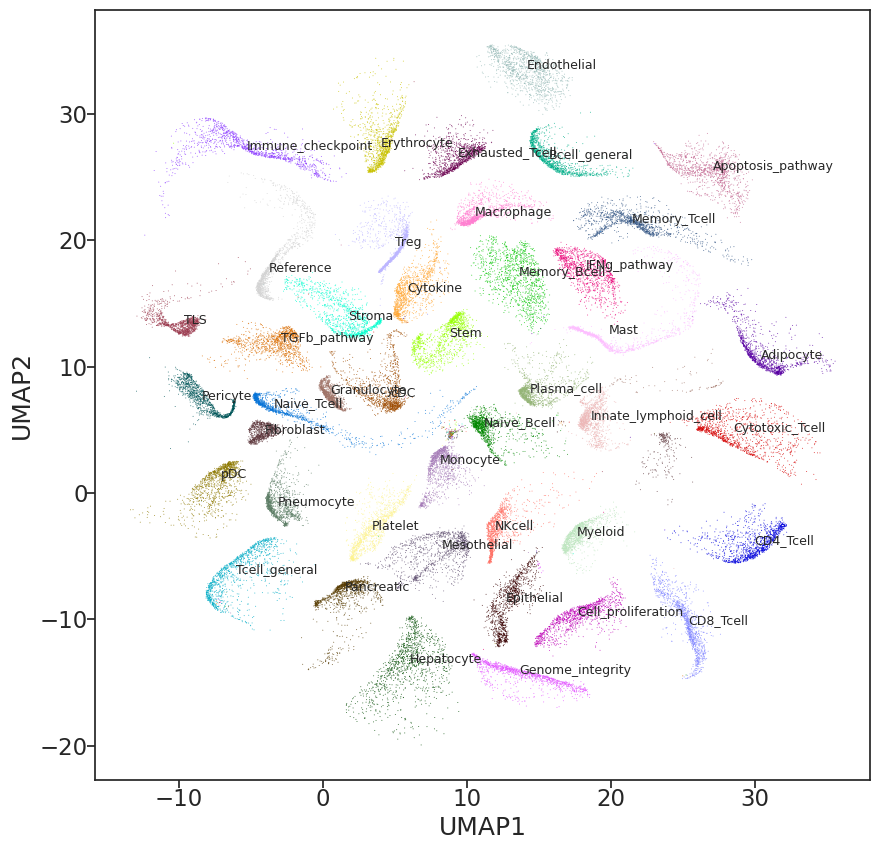

In [14]:
dfp = df2d[df2d.domain == 'ITRP']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

#fig.savefig('cell_ITRP_UMAP_labelled.pdf', bbox_inches ='tight')

## UMAP Overlay

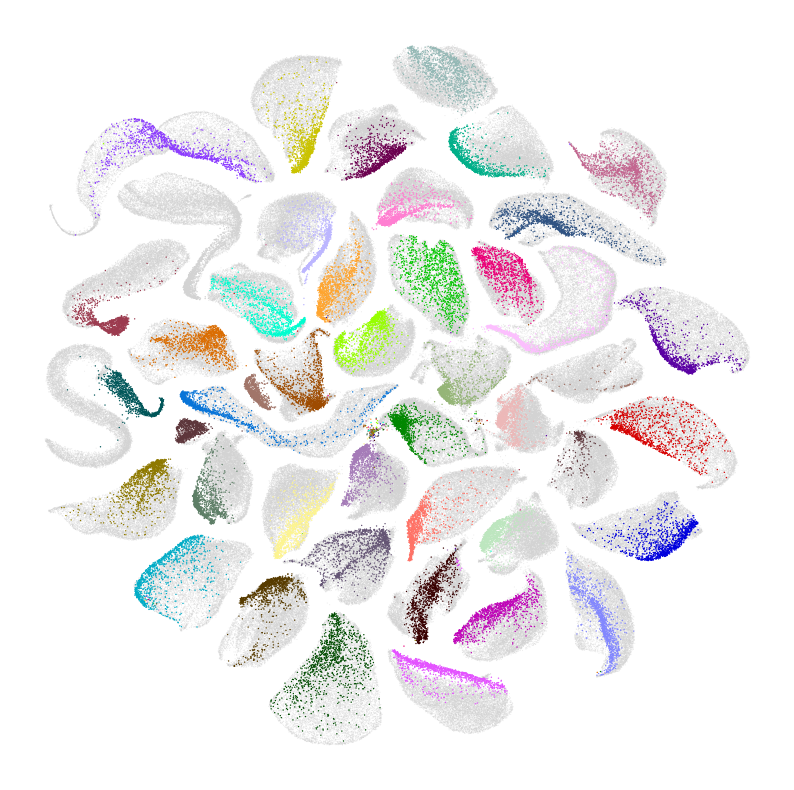

In [8]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.5,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 1,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

# mean = dfp2.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.axis('off')

#fig.savefig('cell_overlay_UMAP_labelled.pdf', bbox_inches ='tight')
fig.savefig('cell_overlay_UMAP_labelled.jpg', bbox_inches ='tight', dpi=500)

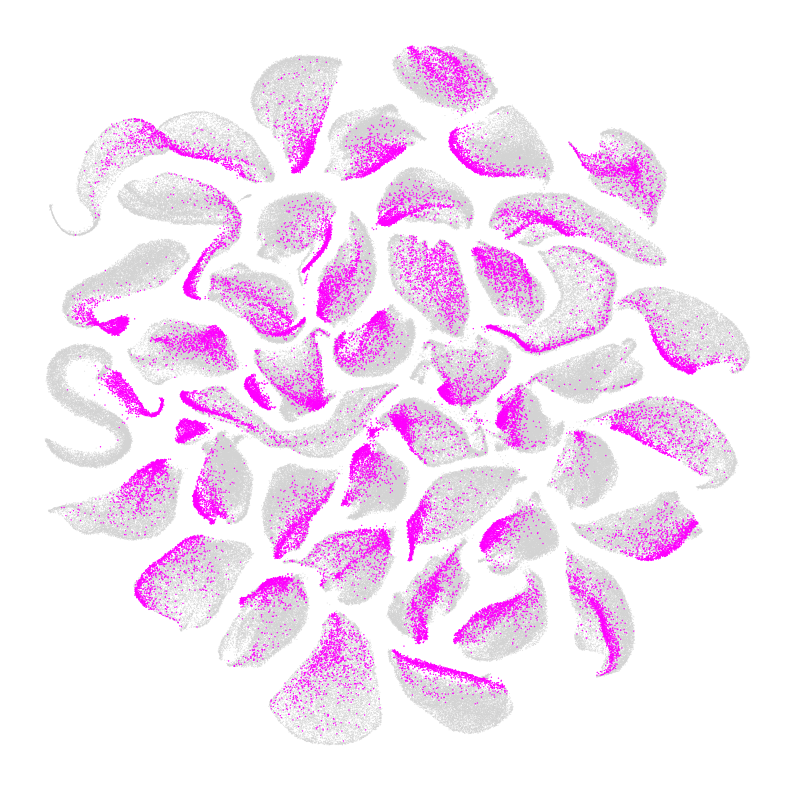

In [17]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


def add_legend(ax, markersize = 1):
    handles = []
    point1 = Line2D([0], [0], label='TCGA', marker='o', markersize=markersize, 
             markeredgecolor=list(background_color.values())[0], linestyle='',
                   markerfacecolor=list(background_color.values())[0],)
    
    point2 = Line2D([0], [0], label='ITRP', marker='o', markersize=markersize, 
             markeredgecolor=list(overlay_color.values())[0], linestyle='',
                   markerfacecolor=list(overlay_color.values())[0],)
    
    # add manual symbols to auto legend
    handles.extend([point1, point2])
    
    ax.legend(handles=handles, numpoints=5)
    

dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = {i:'#ff00ff' for i in hue_order}

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 1,
                linewidth=0.0, hue_order = hue_order, palette=overlay_color, s = 1, 
                 ax=ax, legend=False)

#add_legend(ax)
# mean = dfp1.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
plt.axis('off')

# fig.savefig('cell_overlay_UMAP_unlabelled.pdf', bbox_inches ='tight')
# fig.savefig('cell_overlay_UMAP_unlabelled.jpg', bbox_inches ='tight', dpi=1000)

## PCA Overlay